In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import scipy.sparse as sp

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import StandardScaler


In [4]:
X_train = joblib.load("../models/X_train_processed.pkl")
X_val = joblib.load("../models/X_val_processed.pkl")
y_train = joblib.load("../models/y_train.pkl")
y_val = joblib.load("../models/y_val.pkl")

# Convert to sparse (critical)
X_train_sparse = sp.csr_matrix(X_train)
X_val_sparse = sp.csr_matrix(X_val)

print("Shapes:", X_train_sparse.shape, X_val_sparse.shape)


Shapes: (2120440, 4798810) (530110, 4798810)


LIGHTGBM HYPERPARAMETER TUNING

In [ ]:
#Define Search Space
param_dist = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.03, 0.05],
    "max_depth": [5, 7, 9, -1],
    "num_leaves": [31, 63, 127],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_samples": [20, 50, 100]
}


Randomized Search

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

lgb = LGBMClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    n_jobs=-1,
    random_state=42,
    n_estimators=500,
    early_stopping_round=50
)

param_dist = {
    "num_leaves": [31, 63],
    "max_depth": [5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.6, 0.8]
}

search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_dist,
    n_iter=3,
    scoring="roc_auc",
    cv=None,
    verbose=1,
    random_state=42
)

search.fit(
    X_train_sparse, y_train,
    eval_set=[(X_val_sparse, y_val)],
    eval_metric="auc"
)

best_lgb = search.best_estimator_
print("Best Params:", search.best_params_)

Evaluate Tuned LightGBM

In [ ]:
lgb_probs = best_lgb.predict_proba(X_val_sparse)[:, 1]
lgb_preds = (lgb_probs >= 0.5).astype(int)

print("===== TUNED LIGHTGBM =====")
print(f"Accuracy: {accuracy_score(y_val, lgb_preds):.4f}")
print(f"F1-score: {f1_score(y_val, lgb_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, lgb_probs):.4f}")
print("\nClassification Report:\n", classification_report(y_val, lgb_preds))


Save

In [ ]:
joblib.dump(best_lgb, "../models/lightgbm_tuned.pkl")
print("Saved: ../models/lightgbm_tuned.pkl")


🧠SHAP EXPLAINABILITY

In [5]:
import joblib

best_lgb = joblib.load("../models/lightgbm_tuned.pkl")
print("Loaded LightGBM model")

Loaded LightGBM model


In [8]:
import numpy as np
import pandas as pd

importances = best_lgb.feature_importances_

feat_imp = pd.DataFrame({
    "feature_index": np.arange(len(importances)),
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp.head(20)

,feature_index,importance
20,20,1337
4797143,4797143,474
21,21,325
19,19,214
5,5,191
4797179,4797179,170
6,6,167
2120544,2120544,157
52,52,143
2,2,134


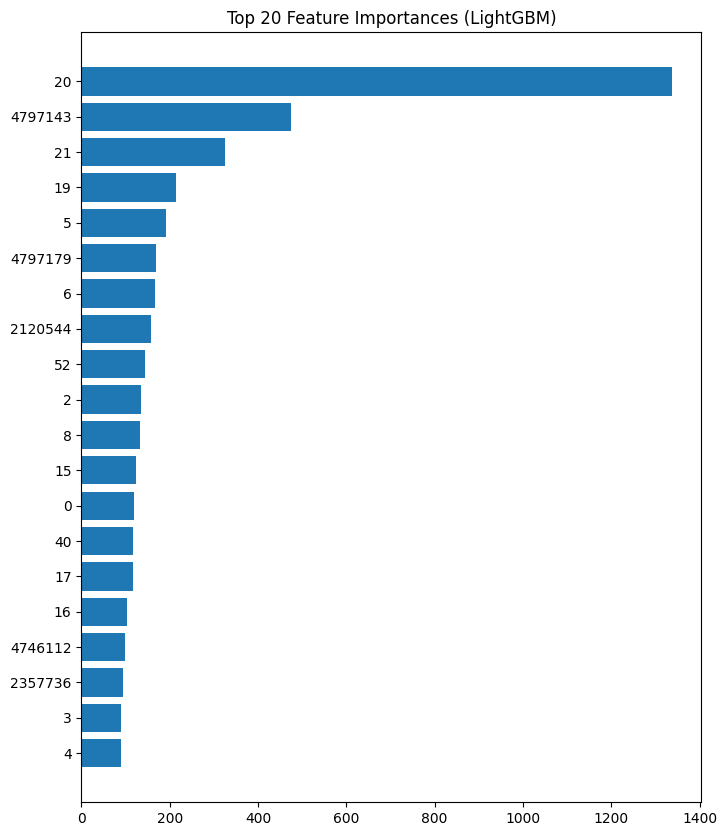

In [9]:
import matplotlib.pyplot as plt

top = feat_imp.head(20)

plt.figure(figsize=(8, 10))
plt.barh(top["feature_index"].astype(str), top["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()

In [10]:
#Load Logistic Regression
logreg = joblib.load("../models/logreg_baseline.pkl")


In [11]:
#Get Probabilities from Both Models
logreg_probs = logreg.predict_proba(X_val)[:, 1]
lgb_probs = best_lgb.predict_proba(X_val_sparse)[:, 1]


X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [12]:
#SIMPLE AVERAGE ENSEMBLE
ensemble_probs = (logreg_probs + lgb_probs) / 2
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

print("===== ENSEMBLE RESULTS =====")
print(f"Accuracy: {accuracy_score(y_val, ensemble_preds):.4f}")
print(f"F1-score: {f1_score(y_val, ensemble_preds):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, ensemble_probs):.4f}")


===== ENSEMBLE RESULTS =====
Accuracy: 0.9596
F1-score: 0.8282
ROC-AUC: 0.9901


In [13]:
#THRESHOLD TUNING
thresholds = np.linspace(0.2, 0.8, 7)

results = []
for t in thresholds:
    preds_t = (ensemble_probs >= t).astype(int)
    results.append((t,
                    accuracy_score(y_val, preds_t),
                    f1_score(y_val, preds_t)))

results_df = pd.DataFrame(results, columns=["threshold", "accuracy", "f1"])
print(results_df)

best_t = results_df.loc[results_df["f1"].idxmax(), "threshold"]
print("Best threshold:", best_t)


   threshold  accuracy        f1
0        0.2  0.918779  0.714195
1        0.3  0.938730  0.766153
2        0.4  0.951270  0.802568
3        0.5  0.959578  0.828249
4        0.6  0.965326  0.846496
5        0.7  0.969352  0.858799
6        0.8  0.971938  0.864690
Best threshold: 0.8


In [14]:
#Final predictions:
final_preds = (ensemble_probs >= best_t).astype(int)
print("Tuned Ensemble F1:", f1_score(y_val, final_preds))


Tuned Ensemble F1: 0.8646898308168092


In [15]:
#Save Ensemble
joblib.dump({
    "logreg": logreg,
    "lightgbm": best_lgb,
    "threshold": best_t
}, "../models/ensemble_model.pkl")

print("Saved: ../models/ensemble_model.pkl")


Saved: ../models/ensemble_model.pkl
